In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np 
import sklearn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the DATASET

The healthexp dataset included with Seaborn is a historical dataset that explores the relationship between health expenditure and life expectancy across various countries and years. It contains data points for several countries, from 1970 to 1980

In [2]:
healthexp = sns.load_dataset('healthexp')
healthexp.head()

,Year,Country,Spending_USD,Life_Expectancy
0,1970,Germany,252.311,70.6
1,1970,France,192.143,72.2
2,1970,Great Britain,123.993,71.9
3,1970,Japan,150.437,72.0
4,1970,USA,326.961,70.9


pd.get_dummies is a powerful function used to convert categorical data into one-hot encoded dummy variables. These dummy variables are binary (0 or 1) features that represent the presence or absence of a particular category within the original data.

In [3]:
healthexp=pd.get_dummies(healthexp)
healthexp.head()

,Year,Spending_USD,Life_Expectancy,Country_Canada,Country_France,Country_Germany,Country_Great Britain,Country_Japan,Country_USA
0,1970,252.311,70.6,False,False,True,False,False,False
1,1970,192.143,72.2,False,True,False,False,False,False
2,1970,123.993,71.9,False,False,False,True,False,False
3,1970,150.437,72.0,False,False,False,False,True,False
4,1970,326.961,70.9,False,False,False,False,False,True


In [4]:
x= healthexp.drop(['Life_Expectancy'],axis=1)
y= healthexp['Life_Expectancy']

# Split the test and train

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=42 )

# Define the model and calculate the loss without tuning

In [6]:
from sklearn.ensemble import RandomForestRegressor
rfr= RandomForestRegressor(random_state=34)
rfr.fit(x_train, y_train)

RandomForestRegressor(random_state=34)

In [8]:
y_pred= rfr.predict(x_test)

In [9]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
MAE=mean_absolute_error (y_test, y_pred)
MAE

0.27123636363635395

In [10]:
MSE=mean_squared_error(y_test, y_pred)
MSE

0.11941941818180976

In [11]:
R2score=r2_score(y_test, y_pred)
R2score

0.990218403745801

# Install ***OPTUNA***

In [12]:
!pip install optuna

In [13]:
import optuna

At this level , we need a function named objective , in order to compare the results I made two functions ,in the second function I used cross validation to improve the results 
I found out in this very example optuna works better without cross validation

In [14]:
def objective (trial): 
    n_estimators=         trial.suggest_int('n_estimators', 10 ,100)    # from a range between 10 to 100
    max_depth=            trial.suggest_int('max_depth' , 10 ,50)
    min_samples_split=    trial.suggest_int('min_samples_split' , 2 ,32)
    min_samples_leaf=     trial.suggest_int('min_samples_leaf' , 1 ,32)
    model= RandomForestRegressor (n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf)
    #score= cross_val_score(model,x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    # Use your preferred metric for regression here (e.g., R-squared)
    metric = mean_squared_error(y_test, y_pred)
    return metric
   

In [15]:
# Define objective function with cross-validation

from sklearn.model_selection import  KFold

def objective2(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    # Loop through cross-validation folds
    for train_index, val_index in kf.split(x_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            random_state=42,
        )
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        # Use your preferred metric for regression here (e.g., R-squared)
        score = mean_squared_error(y_val_fold, y_pred)
        scores.append(score)

    # Return average score across folds as objective
    return np.mean(scores)

# Purpose:

Initiates a new optimization study in Optuna, a framework designed for hyperparameter tuning.
It acts as a container for hyperparameter suggestions, trial results, and optimization history.

Components:

direction (str, optional): Specifies the optimization goal:

'minimize' (default): Minimize the objective value.
'maximize': Maximize the objective value.
sampler (optuna.samplers.BaseSampler, optional): Determines how hyperparameter values are sampled during optimization. Examples:

TPESampler: Tree-structured Parzen Estimator (default)
GridSampler: Grid search
RandomSampler: Random sampling
pruner (optuna.pruners.BasePruner, optional): Decides whether to terminate unpromising trials early to save computational resources. Examples:

MedianPruner (default)
NopPruner: No pruning
study_name (str, optional): Assigns a name to the study for easy identification.

storage (optuna.storages.BaseStorage, optional): Specifies how optimization results are stored. Examples:

InMemoryStorage (default)
RDBStorage: Relational database storage
RedisStorage: Redis storage
load_if_exists (bool, optional): If True, loads an existing study with the same name from storage.

note : help(optuna.create_study)

Minimize:

Most common choice: For many machine learning tasks, metrics like loss functions or error rates are minimized. Reducing these values indicates better performance.
Direct interpretation: With minimization, the lower the objective value, the better. This intuitively aligns with how we typically evaluate model performance.
Simple optimization: Optimization algorithms generally work better with minimization problems as they often directly translate to minimization in the loss function landscape.

Maximize:

Applicable for specific metrics: Certain metrics, like R-squared or accuracy, represent model performance better when maximized.
Requires conversion: When using maximization with such metrics, you need to explicitly negate the objective value before returning it to Optuna. This ensures the optimization algorithm seeks the highest (most positive) result, which translates to better performance in your metric.
Less common: While technically possible, maximizing is less common in practice, especially when dealing with error or loss metrics.

In [16]:
study= optuna.create_study(direction='minimize',sampler=optuna.samplers.RandomSampler(42) )

[I 2024-01-23 11:40:39,902] A new study created in memory with name: no-name-6d1e4cd1-0642-4ebd-80a3-3e12f848e444


In [17]:
study.optimize(objective, n_trials=200)
#study.optimize(objective2, n_trials=200)

[I 2024-01-23 11:40:54,882] Trial 0 finished with value: 2.0375745895161628 and parameters: {'n_estimators': 44, 'max_depth': 48, 'min_samples_split': 24, 'min_samples_leaf': 20}. Best is trial 0 with value: 2.0375745895161628.
[I 2024-01-23 11:40:54,927] Trial 1 finished with value: 2.347511025376453 and parameters: {'n_estimators': 24, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 28}. Best is trial 0 with value: 2.0375745895161628.
[I 2024-01-23 11:40:55,033] Trial 2 finished with value: 2.5575224782583224 and parameters: {'n_estimators': 64, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 32}. Best is trial 0 with value: 2.0375745895161628.
[I 2024-01-23 11:40:55,185] Trial 3 finished with value: 0.6272110668000195 and parameters: {'n_estimators': 85, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.6272110668000195.
[I 2024-01-23 11:40:55,250] Trial 4 finished with value: 0.9416967999316626 and parameters: {

#  Now we see the best Parameters for our ForestRegressor

In [18]:
study.best_params

{'n_estimators': 94,
 'max_depth': 45,
 'min_samples_split': 3,
 'min_samples_leaf': 1}

# Visualization

In [19]:
import matplotlib.pyplot as pyplot
optuna.visualization.plot_optimization_history(study)

In [20]:
optuna.visualization.plot_parallel_coordinate(study)

In [21]:
optuna.visualization.plot_slice(study, params=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'])

In [ ]:
optuna.visualization.plot_param_importances(study)

# Choosing the best parameters in the model

In [22]:
best_n_estimators=       study.best_params['n_estimators']
best_max_depth=          study.best_params['max_depth']
best_min_samples_split=  study.best_params['min_samples_split']
best_min_samples_leaf=   study.best_params['min_samples_leaf']

In [23]:
best_model= RandomForestRegressor(n_estimators=best_n_estimators,
                                  max_depth=best_max_depth,
                                  min_samples_split=best_min_samples_split,
                                  min_samples_leaf=best_min_samples_leaf)
best_model.fit(x_train,y_train)

RandomForestRegressor(max_depth=45, min_samples_split=3, n_estimators=94)

In [24]:
y_pred_optuna= best_model.predict(x_test)

In [25]:
MAE_optuna=mean_absolute_error (y_test, y_pred_optuna)
MAE_optuna

0.29021704890853434

In [26]:
MSE_optuna=mean_squared_error(y_test, y_pred_optuna)
MSE_optuna

0.12808023371352711

In [27]:
R2score_optuna=r2_score(y_test, y_pred_optuna)
R2score_optuna

0.9895089998477316

# Now we use GridSearchCv to find the hyperparameters

In [32]:
from sklearn.model_selection import GridSearchCV

'''
n_estimators_values = [i for i in range(10, 100,3)]
max_depth_values = [i for i in range(10, 50,3)]
min_samples_split_value=[i for i in range(2, 32,3)]
min_samples_leaf_value=[i for i in range(1, 32,3)]

param_grid = {
    "n_estimators": n_estimators_values,
    "max_depth": max_depth_values,
    "min_samples_leaf": min_samples_leaf_value,
    "min_samples_split": min_samples_split_value,
}
'''


# Define parameters to tune
param_grid = {
    "n_estimators": [10,20,30,40, 50,85,95],
    "max_depth": [5, 10, 20,30,35,40,45],
    "min_samples_leaf": [1,2,3,5,7],
    "min_samples_split": [1,2,3, 5, 10],
}



# Create GridSearchCV object
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error")

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Access best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print results
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# Get and use the best model
best_model_GScv = grid_search.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


1225 fits failed out of a total of 6125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1225 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklear

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 85}
Best score: -0.184334438941606


In [34]:
best_model_GScv.fit(x_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=85, random_state=42)

In [35]:
y_pred_GScv= best_model_GScv.predict(x_test)

In [36]:
MAE_GScv=mean_absolute_error (y_test, y_pred_GScv)
MAE_GScv

0.27751871657753135

In [37]:
MSE_GScv=mean_squared_error (y_test, y_pred_GScv)
MSE_GScv

0.12750253538847997

In [38]:
R2Score_GScv=r2_score (y_test, y_pred_GScv)
R2Score_GScv

0.989556318883935

# Result Comparison

In [42]:
column_names = ['Method', 'MAE', 'MSE', 'R-squared']
results_df = pd.DataFrame(columns=column_names)
results_df

,Method,MAE,MSE,R-squared


In [50]:

# Create lists of results for each method
method_names = ['RandomForest', 'Optuna-tuned', 'GridSearchCV-tuned']
mae_values = [MAE,MAE_optuna,MAE_GScv,]
mse_values = [MSE,MSE_optuna,MSE_GScv,]
r2_values = [R2score, R2score_optuna,R2Score_GScv]

# Create the DataFrame
data = {'Method': method_names, 'MAE': mae_values, 'MSE': mse_values, 'R-squared': r2_values}
results_df = pd.DataFrame(data)

results_df

,Method,MAE,MSE,R-squared
0,RandomForest,0.271236,0.119419,0.990218
1,Optuna-tuned,0.290217,0.128080,0.989509
2,GridSearchCV-tuned,0.277519,0.127503,0.989556


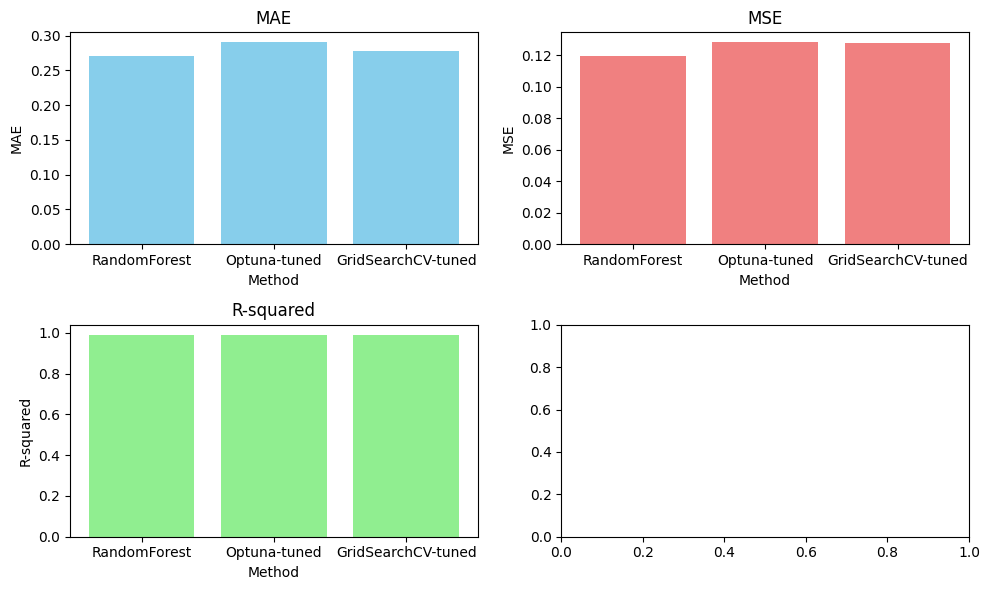

In [51]:
import matplotlib.pyplot as plt

# Create the bar graph
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

metrics = ['MAE', 'MSE', 'R-squared']
colors = ['skyblue', 'lightcoral', 'lightgreen']  # Customize colors if desired

for i, metric in enumerate(metrics):
    column_name = metric
    axis = axes.flat[i]
    axis.bar(results_df['Method'], results_df[column_name], color=colors[i])
    axis.set_title(metric)
    axis.set_xlabel('Method')
    axis.set_ylabel(metric)

fig.tight_layout()
plt.show()